### Data preprocessing

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_precision_score, flat_recall_score, flat_f1_score
from nltk.tokenize import word_tokenize

In [20]:
# Ensure required NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bika\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
# Load dataset from text file
file_path = "Pollutants1.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read().lower()  # Convert to lowercase

In [22]:
# Expand abbreviations
abbreviations = {"noael": "no observed adverse effect level", "loael": "lowest observed adverse effect level", "who": "world health organization"}
for abbr, full_form in abbreviations.items():
    text = text.replace(abbr, full_form)

In [23]:
# Remove punctuation but keep periods
text = re.sub(r'[^a-zA-Z0-9.\s]', '', text)

In [24]:
# Convert units to a consistent format
text = text.replace("µg/m³", "ug/m3").replace("mg/m³", "mg/m3").replace("bq/m³", "bq/m3")

In [25]:
# Handling numbers
text = re.sub(r'\d+', lambda x: f"{int(x.group()):,}", text)

In [26]:
sentences = sent_tokenize(text)
print(f"Original sentence count: {len(sent_tokenize(text))}")
# print(f"After preprocessing: {len(unique_sentences)}")

Original sentence count: 109


In [27]:
# Removing stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in word_tokenize(text) if word.lower() not in stop_words]
print(f"Word count before stopwords removal: {len(word_tokenize(text))}")
print(f"Word count after stopwords removal: {len(filtered_words)}")

Word count before stopwords removal: 2960
Word count after stopwords removal: 1877


In [28]:
# Stemming & Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stemmed_words = [stemmer.stem(word) for word in filtered_words]
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
print("Sample Stemming:", stemmed_words[:10])
print("Sample Lemmatization:", lemmatized_words[:10])

Sample Stemming: ['guidelin', 'exposur', 'level', 'indoor', 'air', 'need', 'indoor', 'air', 'signific', 'sourc']
Sample Lemmatization: ['guideline', 'exposure', 'level', 'indoor', 'air', 'needed', 'indoor', 'air', 'significant', 'source']


In [29]:
# Removing Redundancy
unique_sentences = list(dict.fromkeys(sentences))
print(f"Unique sentences count: {len(unique_sentences)}")

Unique sentences count: 109


In [30]:
# Bag of Words
vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(unique_sentences)
print("Bag of Words - Matrix shape:", vectorized_data.shape)

Bag of Words - Matrix shape: (109, 676)


In [41]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X = vectorizer_tfidf.fit_transform(unique_sentences)
y = [1 if any(pollutant in sentence for pollutant in pollutants) else 0 for sentence in unique_sentences]

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Save preprocessed text
output_txt_path = "Preprocessed_Pollutants1.txt"
with open(output_txt_path, "w", encoding="utf-8") as file:
    file.write("\n".join(unique_sentences))
print(f"Preprocessed data saved to {output_txt_path}")

Preprocessed data saved to Preprocessed_Pollutants1.txt


In [44]:
# Exploratory Data Analysis (EDA)
# Original pollutant list
pollutants = [
    "benzene", "carbon monoxide", "formaldehyde", "naphthalene",
    "nitrogen dioxide", "polycyclic aromatic hydrocarbons", "radon",
    "trichloroethylene", "tetrachloroethylene", "carboxyhemoglobin"
]

# Tokenize each pollutant phrase into separate words
pollutant_words = set()
for phrase in pollutants:
    words = word_tokenize(phrase)  # Tokenize each phrase
    pollutant_words.update(words)  # Add each word to the set

print("Final pollutant words:", pollutant_words)


Final pollutant words: {'nitrogen', 'monoxide', 'carbon', 'hydrocarbons', 'trichloroethylene', 'tetrachloroethylene', 'dioxide', 'carboxyhemoglobin', 'polycyclic', 'naphthalene', 'formaldehyde', 'aromatic', 'benzene', 'radon'}


In [45]:
# Count occurrences of pollutants
pollutant_counts = Counter(word for word in filtered_words if word in pollutants)
print("Pollutant Counts:", pollutant_counts)

Pollutant Counts: Counter({'benzene': 15, 'naphthalene': 7, 'radon': 6, 'formaldehyde': 5, 'tetrachloroethylene': 2, 'carboxyhemoglobin': 1, 'trichloroethylene': 1})


In [46]:
# Convert to DataFrame for visualization
df_pollutants = pd.DataFrame(pollutant_counts.items(), columns=["Pollutant", "Count"])
df_pollutants.sort_values(by="Count", ascending=False, inplace=True)

C:\Users\Bika\AppData\Local\Temp\ipykernel_17016\3279029077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_pollutants["Pollutant"], y=df_pollutants["Count"], palette="coolwarm")


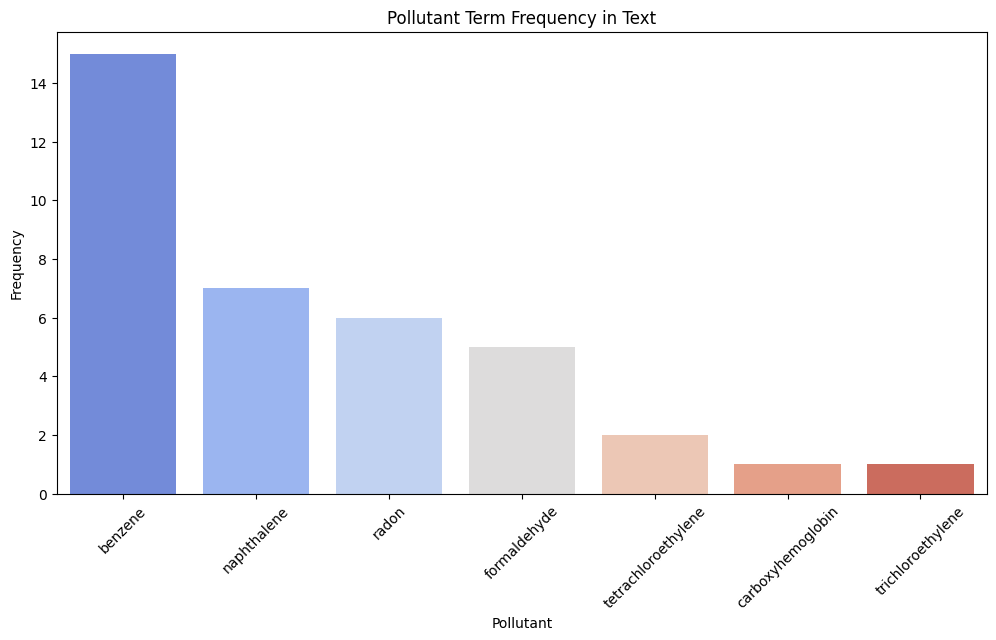

In [47]:
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=df_pollutants["Pollutant"], y=df_pollutants["Count"], palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Pollutant")
plt.ylabel("Frequency")
plt.title("Pollutant Term Frequency in Text")
plt.show()

Descriptive Statistics:
           Count
count   7.000000
mean    5.285714
std     4.923220
min     1.000000
25%     1.500000
50%     5.000000
75%     6.500000
max    15.000000


C:\Users\Bika\AppData\Local\Temp\ipykernel_17016\1257338718.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df_pollutants["Count"], palette="coolwarm")


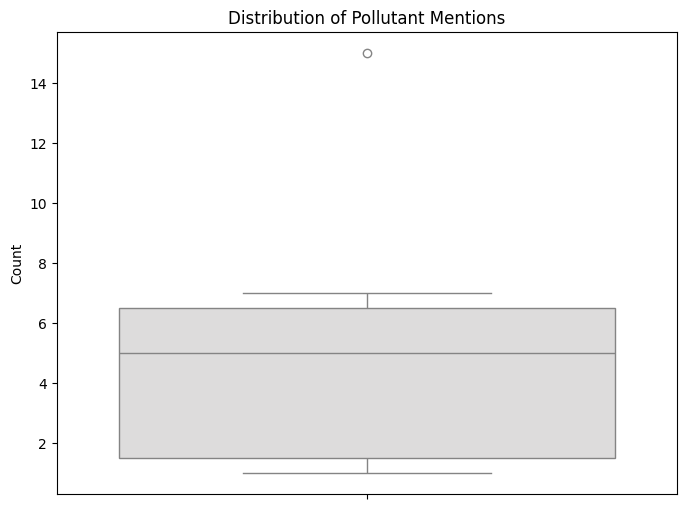

In [48]:
# Descriptive statistics
print("Descriptive Statistics:")
print(df_pollutants.describe())

# Box plot for distribution analysis
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_pollutants["Count"], palette="coolwarm")
plt.title("Distribution of Pollutant Mentions")
plt.show()

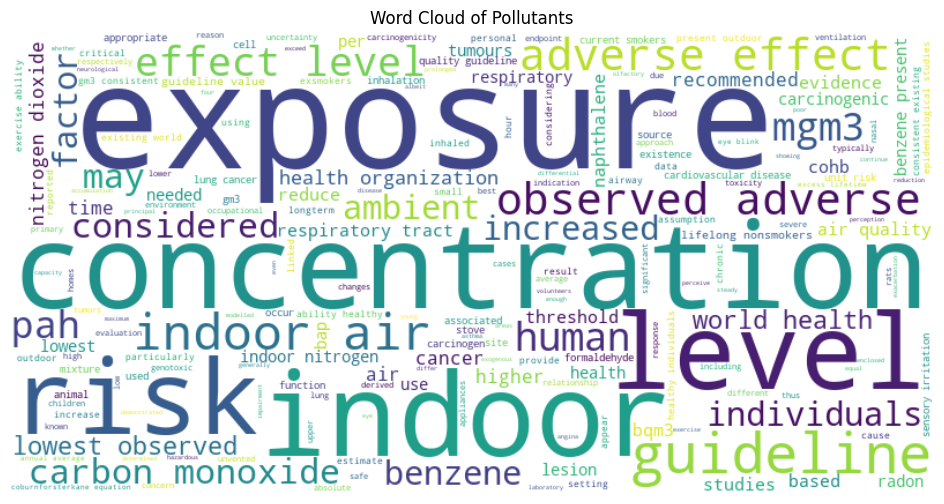

In [49]:
# Word Cloud
plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Pollutants")
plt.show()

### Models

In [50]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)  # Define the model
log_reg.fit(X_train, y_train)  # Train the model
y_pred = log_reg.predict(X_test)
log_reg_scores = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, zero_division=1), recall_score(y_test, y_pred, zero_division=1), f1_score(y_test, y_pred, zero_division=1)]
print("Logistic Regression (Default Parameters) Results:")
print(classification_report(y_test, y_pred, zero_division=1))

Logistic Regression (Default Parameters) Results:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       1.00      0.55      0.71        11

    accuracy                           0.77        22
   macro avg       0.84      0.77      0.76        22
weighted avg       0.84      0.77      0.76        22



In [51]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_scores = [accuracy_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf, zero_division=1), recall_score(y_test, y_pred_rf, zero_division=1), f1_score(y_test, y_pred_rf, zero_division=1)]
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.73      0.84        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22



In [52]:
# CRF Model for Named Entity Recognition

def extract_crf_features(sentence):
    words = word_tokenize(sentence)
    return [{'word': word.lower()} for word in words]

X_crf = [extract_crf_features(sentence) for sentence in unique_sentences]
y_crf = [[str(1) if word in pollutants else str(0) for word in word_tokenize(sentence)] for sentence in unique_sentences]

crf_model = CRF(algorithm="lbfgs")
crf_model.fit(X_crf, y_crf)
crf_predictions = crf_model.predict(X_crf)

In [53]:
# Convert CRF predictions to binary format
binary_crf_results = [[int(label) for label in prediction] for prediction in crf_predictions]
print("CRF Model Predictions (0 = Non-Pollutant, 1 = Pollutant):")
print(binary_crf_results[:20])  

CRF Model Predictions (0 = Non-Pollutant, 1 = Pollutant):
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0

In [54]:
# Evaluate Logistic Regression
log_reg_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_precision = precision_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)

# Evaluate Random Forest
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

# Store scores for plotting
log_reg_scores = [log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]

# Print Evaluation Results
print("Logistic Regression Results:")
print(f"Accuracy: {log_reg_accuracy:.4f}, Precision: {log_reg_precision:.4f}, Recall: {log_reg_recall:.4f}, F1-score: {log_reg_f1:.4f}")

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}, Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, F1-score: {rf_f1:.4f}")

Logistic Regression Results:
Accuracy: 0.7727, Precision: 1.0000, Recall: 0.5455, F1-score: 0.7059

Random Forest Results:
Accuracy: 0.8636, Precision: 1.0000, Recall: 0.7273, F1-score: 0.8421


In [55]:
# Ensure that both y_crf and crf_predictions are properly structured
if isinstance(y_crf[0], list) and isinstance(crf_predictions[0], list):
    y_crf_flat = [label for sentence in y_crf for label in sentence]
    crf_pred_flat = [label for sentence in crf_predictions for label in sentence]
else:
    raise ValueError("y_crf and crf_predictions must be lists of lists (one per sentence).")

# Evaluate CRF properly
crf_accuracy = accuracy_score(y_crf_flat, crf_pred_flat)
crf_precision = flat_precision_score(y_crf, crf_predictions, average='weighted')
crf_recall = flat_recall_score(y_crf, crf_predictions, average='weighted')
crf_f1 = flat_f1_score(y_crf, crf_predictions, average='weighted')

print("\nCRF Model Results:")
print(f"Accuracy: {crf_accuracy:.4f}, Precision: {crf_precision:.4f}, Recall: {crf_recall:.4f}, F1-score: {crf_f1:.4f}")


CRF Model Results:
Accuracy: 0.9889, Precision: 0.9890, Recall: 0.9889, F1-score: 0.9844


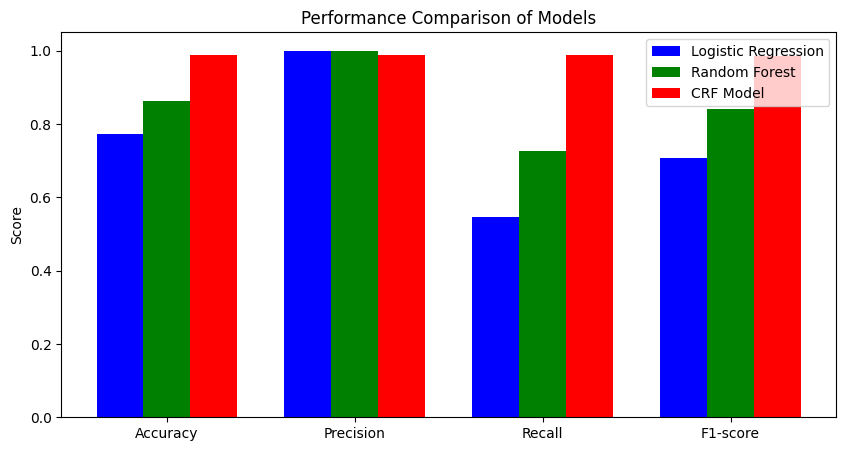

In [56]:
crf_scores = [crf_accuracy, crf_precision, crf_recall, crf_f1]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Compare all models visually
plt.figure(figsize=(10,5))
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, log_reg_scores, width, label="Logistic Regression", color="blue")
plt.bar(x, rf_scores, width, label="Random Forest", color="green")
plt.bar(x + width, crf_scores, width, label="CRF Model", color="red")

plt.xticks(ticks=x, labels=metrics)
plt.ylabel("Score")
plt.title("Performance Comparison of Models")
plt.legend()
plt.show()